Rohan Bhatt - MSML604 HW7

In [ ]:
#problem 1
import numpy as np
import matplotlib.pyplot as plt

#defining the problem data, setting all types to floats for numpy calc purposes
P = np.array([[5, 4, 6],
              [4, 9, 15],
              [6, 15, 35]], dtype=float)
q = np.array([5, 7, 6], dtype=float)
#initial point
x0 = np.array([2, 4, 6], dtype=float) 

#defining f(x) as stated in the problem:
def f(x):
    return .5*x @ P @ x + q @ x
#defining the gradient of f(x)
def grad(x):
    return P @ x + q

#part a (armijo backtracking)
def gradient(x0, alpha_init=2, gamma=0.5, beta=0.8, tol=1e-10, max_iterations=2_000, verbose = False): #putting alpha gamma beta in the parameters, along with the tolerance for convergence
    x = x0.copy().astype(float) #copying the initial point
    f_hist = [f(x)]
    for k in range(max_iterations):
        g = grad(x) #current gradient
        #stopping test
        if np.linalg.norm(g) < tol:
            if verbose:
                print(f"Converged ‖∇f‖={np.linalg.norm(g):.2e} at k={k}")
            break
        #armijo line search
        alpha = alpha_init #starting with a_initi
        #condition is f( x - alpha*g) <= f(x) - beta*alpha*np.linalg.norm(g)**2
        while f(x - alpha * g) > f(x) - beta * alpha * (g @ g):
            alpha *= gamma # shrink α ← γ α
            #print(f"alpha: {alpha}")

        #gradient descent step
        x = x - alpha * g
        f_hist.append(f(x))
        if verbose:
            print(f"Iteration {k}: x = {x}, f(x) = {f_hist[-1]}, alpha = {alpha}")
    return x, f_hist #returning the last iterate and the objective values at each iterate (f(x0), f(x1), ...)
x_gd, vals_gd  = gradient(x0)
print(x_gd)
print(vals_gd)


[-0.47552474 -1.45804146  0.53496488]
[1250.0, 552.8991088867188, 246.40335679613054, 111.4582507259953, 51.868383038838886, 25.3898412071853, 13.4706500110642, 7.962815126964439, 5.287146159918638, 3.870836525363692, 2.3585350323278993, 0.8589729224537848, -1.1854568636975578, -1.8496239591138455, -2.7862045545676404, -3.0992187653522842, -3.5592037712617253, -3.851175608705184, -3.965315851503094, -4.132686327200713, -4.198870450383447, -4.384813523556017, -4.407289454475464, -4.459876600199642, -4.4841996619003295, -4.522109689535976, -4.538752556091926, -4.589345777796741, -4.595845512021235, -4.612294329859621, -4.619898532518271, -4.641994717332366, -4.6454461917785155, -4.652795223784527, -4.654831347007811, -4.660677880577259, -4.663285830689558, -4.671288437237959, -4.672327984109974, -4.674972701461014, -4.676196627922373, -4.67976758981106, -4.68032168663074, -4.681512198681222, -4.681840506640762, -4.682787670111344, -4.683209713607562, -4.684507403138258, -4.68467482829809

In [4]:
#1b - using conjugate gradient
def conjugate_gradient(x0, tol=1e-10, max_iterations=10, verbose = False):
    x = x0.copy().astype(float) #copying the initial point
    f_hist = [f(x)]
    r = -grad(x) # initial residual r0 = -∇f(x0)
    p = r.copy() # first search direction
    for k in range(max_iterations):
        Ap = P @ p # matrix-vector product
        alpha = r @ r / (p @ Ap) #exact line search step size
        x = x + alpha * p #update the iterate
        r_new = r + alpha * Ap #new residual (-gradient)

        f_hist.append(f(x))
        if verbose:
            print(f"k={k} ---------------\n α={alpha} ---------------\n ‖r‖={np.linalg.norm(r_new)}"f" ---------------\n f={f_hist[-1]}")
        #convergence test
        if np.linalg.norm(r_new) < tol:
            break
        beta = r_new @ r_new / (r @ r) #fletcher-reeves formula
        p = -r_new + beta * p
        r = r_new

    return x, f_hist 
x_cg, vals_cg = conjugate_gradient(x0)
shift = abs(vals_cg[-1]) + 1 #shifting the values to be positive for plotting

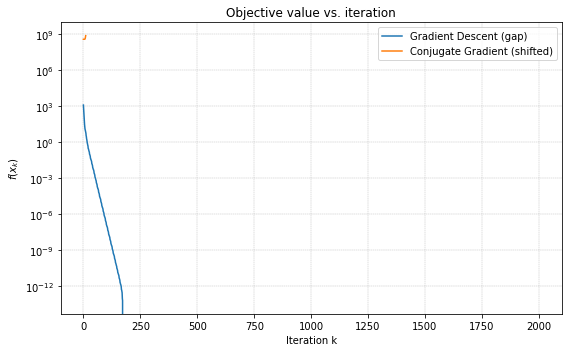

In [5]:
#plots for all parts:
plt.figure(figsize=(8,5))
f_opt = vals_gd[-1]
plt.semilogy(np.array(vals_gd) - f_opt, label="Gradient Descent (gap)")
plt.semilogy(np.array(vals_cg) + shift,  label="Conjugate Gradient (shifted)")
# plt.semilogy(vals_new, label="Newton")
# plt.semilogy(vals_dfp, label="DFP")
# plt.semilogy(vals_bfgs,label="BFGS")
plt.xlabel("Iteration k")
plt.ylabel(r"$f(x_k)$")
plt.title("Objective value vs. iteration")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()